<a href="https://colab.research.google.com/github/emh0841-code/Final-Team9/blob/main/%EA%B0%80%EC%84%A4%EA%B2%80%EC%A6%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

# 필요한 라이브러리 임포트
import pandas as pd # 데이터 분석 라이브러리
import numpy as np
import matplotlib.pyplot as plt # 시각화 도구 라이브러리1
import seaborn as sns # 시각화 도구 라이브러리2

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

df = pd.read_csv("/content/TMDB_processed (2).csv")

In [57]:
# 1. ROI(수익률) 계산 컬럼 추가
df['ROI'] = ((df['revenue'] - df['budget']) / df['budget']) * 100

# 2. SR(흥행 등급) 계산 컬럼 추가
conditions = [
    (df['revenue'] / df['budget']) >= 3,
    (df['revenue'] / df['budget']) >= 2.5,
    (df['revenue'] / df['budget']) >= 2,
]
choices = [3, 2, 1]
df['SR'] = np.select(conditions, choices, default=0)

In [58]:
df["runtime_group"] = np.where(df["runtime"] >= 120, "120분 이상", "120분 미만")
print(df.groupby("runtime_group")["ROI"].agg(["count","mean","median"]))

               count          mean      median
runtime_group                                 
120분 미만         6856  42815.920653   71.140624
120분 이상         2251  69469.847525  121.323755


In [59]:
short = df[df["runtime_group"]=="120분 미만"]["ROI"]
long  = df[df["runtime_group"]=="120분 이상"]["ROI"]

t_stat, p_val = ttest_ind(long, short, equal_var=False)
print(f"t = {t_stat:.4f}, p-value = {p_val:.4g}")

t = 0.3349, p-value = 0.7377


In [60]:
from scipy.stats import mannwhitneyu
u, p = mannwhitneyu(long, short, alternative="two-sided")
print(f"U = {u}, p-value = {p}")

U = 8643578.5, p-value = 1.0660648816667092e-17


<Figure size 800x600 with 0 Axes>

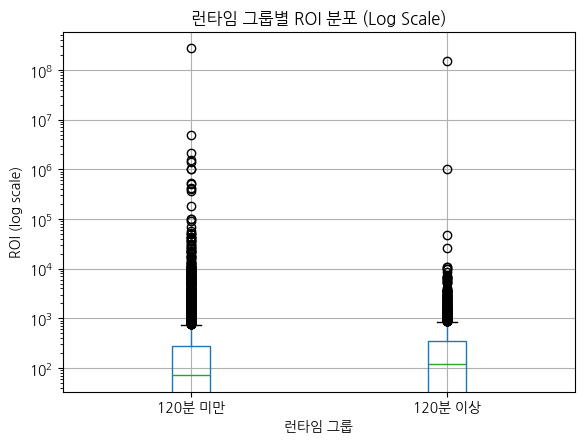

In [61]:
plt.figure(figsize=(8,6))
df.boxplot(column="ROI", by="runtime_group")
plt.yscale("log")  # y축 로그 변환
plt.title("런타임 그룹별 ROI 분포 (Log Scale)")
plt.suptitle("")
plt.xlabel("런타임 그룹")
plt.ylabel("ROI (log scale)")
plt.show()

"러닝타임이 120분 이상일수록 ROI가 높다" → 중앙값과 분포 기준으로 통계적으로 유의,평균만 보면 지지되지 않음

In [62]:
df["genre_list"] = df["genres"].str.split(",").apply(lambda x: [g.strip() for g in x] if isinstance(x, list) else [])
all_genres = df["genre_list"].explode()

genre_counts = all_genres.value_counts()
print("장르별 등장 횟수:\n", genre_counts)

topN = int(len(genre_counts) * 0.3)
top_genres = genre_counts.head(topN).index
print("\n분석할 장르:", list(top_genres))


장르별 등장 횟수:
 genre_list
Drama              4230
Comedy             3192
Thriller           2232
Action             2176
Romance            1700
Adventure          1540
Crime              1379
Horror             1084
Science Fiction     947
Family              904
Fantasy             864
Mystery             781
Animation           508
History             484
Music               366
War                 347
Documentary         193
Western             160
TV Movie             17
Name: count, dtype: int64

분석할 장르: ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance']


In [63]:
target_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance']
results = []

df_exploded = df.explode("genre_list")
df_exploded = df_exploded.rename(columns={"genre_list": "genre"})

for g in target_genres:
    temp = df_exploded[df_exploded["genre"] == g]

    short = temp[temp["runtime_group"]=="120분 미만"]["ROI"]
    long  = temp[temp["runtime_group"]=="120분 이상"]["ROI"]

    if len(short) > 0 and len(long) > 0:
        u, p = stats.mannwhitneyu(long, short, alternative="two-sided")
    else:
        u, p = None, None

    results.append({
        "genre": g,
        "short_count": len(short),
        "long_count": len(long),
        "short_median": short.median() if len(short)>0 else None,
        "long_median": long.median() if len(long)>0 else None,
        "median_diff": (long.median() - short.median()) if len(short)>0 and len(long)>0 else None,
        "p_value": p
    })

genre_summary = pd.DataFrame(results)
print(genre_summary)

      genre  short_count  long_count  short_median  long_median  median_diff  \
0     Drama         2775        1455     37.500000    91.333333    53.833333   
1    Comedy         2787         405     98.020640   159.377251    61.356611   
2  Thriller         1667         565     51.144083   145.390806    94.246722   
3    Action         1468         708     50.083063   154.772727   104.689664   
4   Romance         1211         489     84.434502   129.639733    45.205231   

        p_value  
0  6.316324e-12  
1  2.377688e-06  
2  7.155699e-14  
3  5.961851e-24  
4  1.608406e-04  


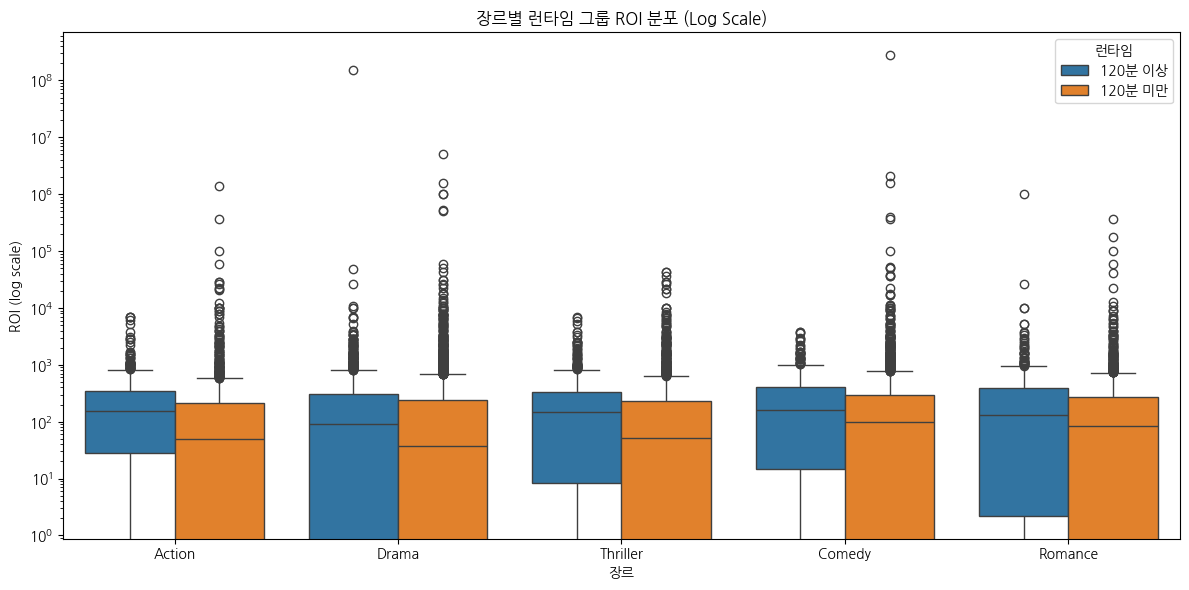

In [64]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_exploded[df_exploded["genre"].isin(target_genres)],
    x="genre",
    y="ROI",
    hue="runtime_group"
)
plt.yscale("log")
plt.title("장르별 런타임 그룹 ROI 분포 (Log Scale)")
plt.xlabel("장르")
plt.ylabel("ROI (log scale)")
plt.legend(title="런타임")
plt.tight_layout()
plt.show()



주요 장르 중에서도 Action과 Thriller는 런타임이 120분 이상일 때 ROI가 크게 높아, 장편일수록 투자 효율이 매우 뛰어난 경향을 보였다.

=== 런타임 그룹별 평점 요약 ===
               count      mean  median
runtime_group                         
120분 미만         6856  6.426785   6.364
120분 이상         2251  6.857606   6.914

평점 비교 → t=19.290, p=3.497e-80 | U-test p=1.031e-123


/tmp/ipython-input-74034069.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="runtime_group", y="vote_average", palette="Set2")


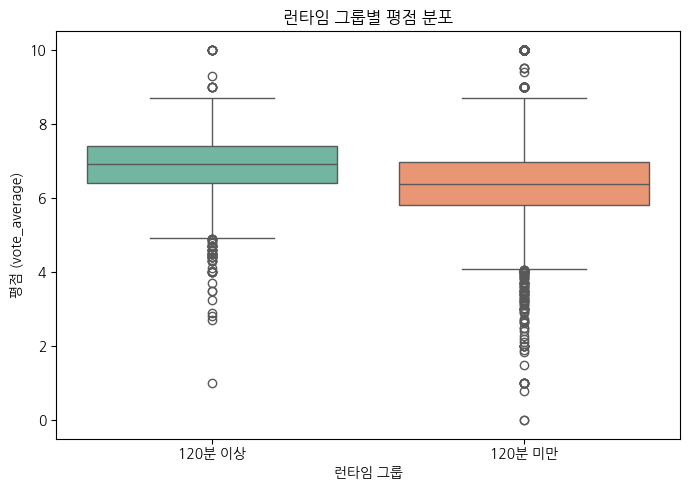

In [79]:

# 1) 런타임 그룹 (이미 있으시다면 생략 가능)
df["runtime_group"] = np.where(df["runtime"] >= 120, "120분 이상", "120분 미만")

# 2) 그룹별 요약 통계
summary_vote = df.groupby("runtime_group")["vote_average"].agg(["count","mean","median"])
print("=== 런타임 그룹별 평점 요약 ===")
print(summary_vote)

# 3) 통계 검정
short = df[df["runtime_group"]=="120분 미만"]["vote_average"].dropna()
long  = df[df["runtime_group"]=="120분 이상"]["vote_average"].dropna()

t_stat, p_val = ttest_ind(long, short, equal_var=False)
u_stat, u_p = mannwhitneyu(long, short, alternative="two-sided")

print(f"\n평점 비교 → t={t_stat:.3f}, p={p_val:.4g} | U-test p={u_p:.4g}")

# 4) 시각화 (Boxplot)
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="runtime_group", y="vote_average", palette="Set2")
plt.title("런타임 그룹별 평점 분포")
plt.xlabel("런타임 그룹")
plt.ylabel("평점 (vote_average)")
plt.tight_layout()
plt.show()



런타임이 2시간 이상인 영화는 평점이 전반적으로 높고 안정적이며, 120분 미만 영화는 변동성이 크고 평균적으로 평점이 낮다.

In [78]:

# Define a list of major studios (This is an example, you might want to customize this list)
major_studios = ["Warner Bros.", "Universal Pictures", "Walt Disney Pictures", "20th Century Fox", "Paramount Pictures", "Columbia Pictures"]

def categorize_scale(row):
    budget = row["budget"]
    studios = str(row.get("production_companies", ""))  # 제작사 문자열

    # 독립영화 (Indie)
    if budget < 20_000_000 and not any(studio in studios for studio in major_studios):
        return "Indie Film"

    # 블록버스터
    elif budget >= 100_000_000:
        return "Blockbuster"

    # 상업영화
    else:
        return "Commercial Film"

df["scale"] = df.apply(categorize_scale, axis=1)

df["runtime_group"] = np.where(df["runtime"] >= 120, "120분 이상", "120분 미만")

summary = df.groupby(["scale", "runtime_group"])["ROI"].agg(["count","mean","median"]).round(2)
print(summary)


results = []
for scale in df["scale"].unique():
    temp = df[df["scale"] == scale]
    short = temp[temp["runtime_group"]=="120분 미만"]["ROI"].dropna()
    long  = temp[temp["runtime_group"]=="120분 이상"]["ROI"].dropna()

    if len(short) > 0 and len(long) > 0:
        u, p = mannwhitneyu(long, short, alternative="two-sided")
        results.append({
            "scale": scale,
            "short_median": short.median(),
            "long_median": long.median(),
            "median_diff": long.median() - short.median(),
            "p_value": p
        })

results_df = pd.DataFrame(results)
print("\n통계 검정 결과:\n", results_df)

                               count       mean  median
scale           runtime_group                          
Blockbuster     120분 미만          239     170.09  135.06
                120분 이상          265     238.55  205.58
Commercial Film 120분 미만         2737     237.49   83.86
                120분 이상          986     241.31   97.95
Indie Film      120분 미만         3880   75478.17   47.45
                120분 이상         1000  156075.47  119.56

통계 검정 결과:
              scale  short_median  long_median  median_diff       p_value
0      Blockbuster    135.058047   205.581341    70.523294  4.392993e-04
1  Commercial Film     83.857631    97.948332    14.090700  1.389840e-02
2       Indie Film     47.451197   119.560019    72.108822  1.901257e-12


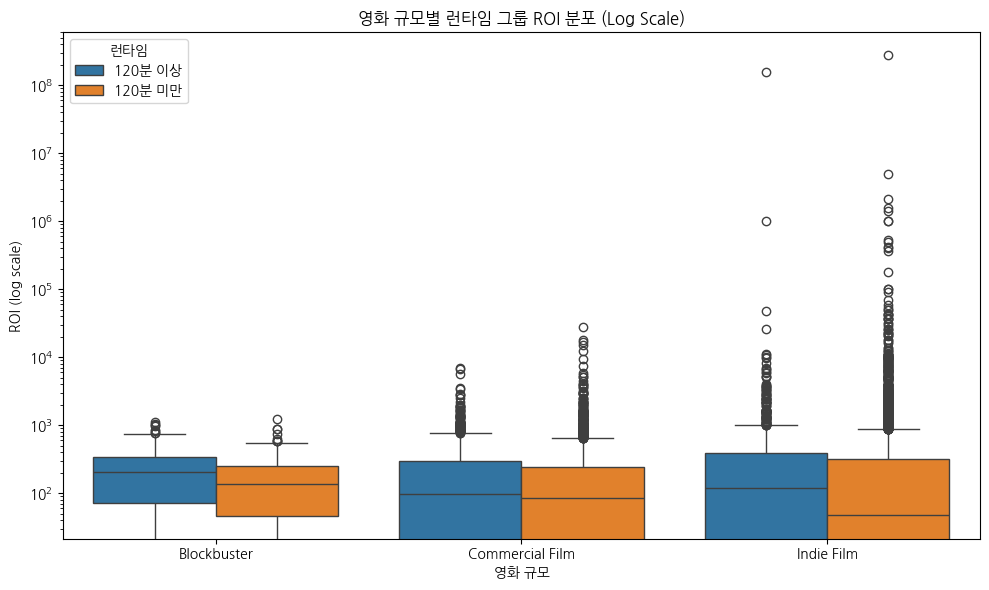

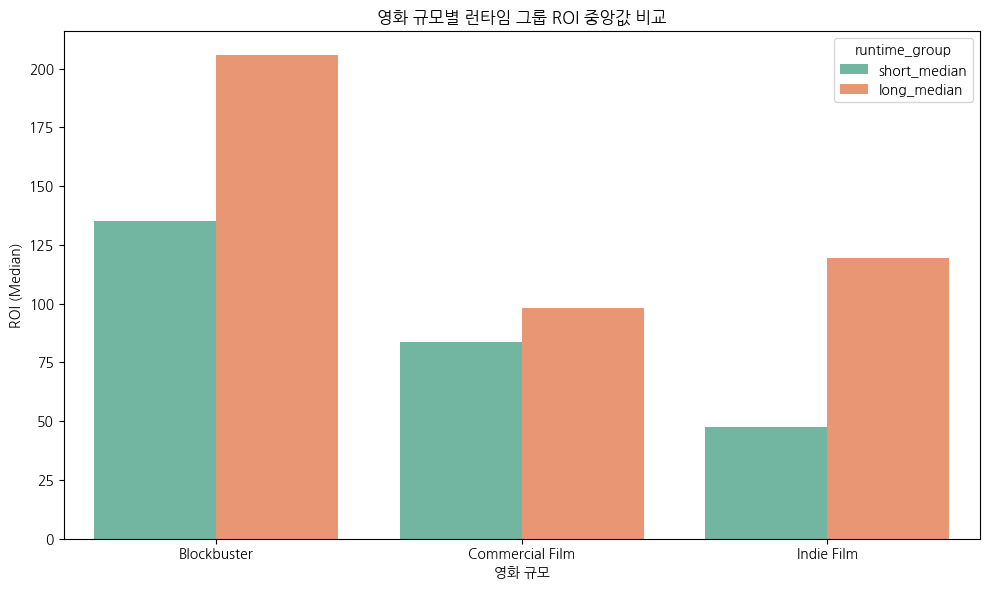

In [76]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="scale", y="ROI", hue="runtime_group")
plt.yscale("log")
plt.title("영화 규모별 런타임 그룹 ROI 분포 (Log Scale)")
plt.xlabel("영화 규모")
plt.ylabel("ROI (log scale)")
plt.legend(title="런타임")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(
    data=results_df.melt(id_vars="scale", value_vars=["short_median","long_median"],
                         var_name="runtime_group", value_name="ROI_median"),
    x="scale", y="ROI_median", hue="runtime_group", palette="Set2"
)
plt.title("영화 규모별 런타임 그룹 ROI 중앙값 비교")
plt.xlabel("영화 규모")
plt.ylabel("ROI (Median)")
plt.tight_layout()
plt.show()

영화 규모와 상관없이 런타임이 2시간 이상일수록 ROI 중앙값이 높다.

특히 인디 영화와 블록버스터에서 효과가 뚜렷하다.

상업영화도 차이가 있으나, 규모가 크다 보니 효과가 상대적으로 작음.